In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


In [2]:
# GPU or CPU device to use
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
Width = 256
Height = 256
K = 20

category = ['Aeroplanes', 'Bicycles', 'Birds', 'Boats', 'Bottles', 
            'Buses', 'Cars', 'Cats', 'Chairs', 'Cows', 
            'Dining tables', 'Dogs', 'Horses', 'Motorbikes', 'People',
            'Potted plants', 'Sheep', 'Sofas',  'Trains', 'TV/Monitors']

In [8]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((Height, Width)),
    transforms.ToTensor(),
    ])

target_transform = transforms.Compose([
    transforms.Resize((Height, Width)),
    transforms.ToTensor(),
    lambda x: (x[0] * 255).long(),
    ])

# choose the training and test datasets
test_data = datasets.VOCSegmentation(root='voc', year='2012', image_set='train', 
                                      download=True, 
                                      transform=transform, 
                                      target_transform=target_transform)
print(test_data)

Using downloaded and verified file: voc/VOCtrainval_11-May-2012.tar
Dataset VOCSegmentation
    Number of datapoints: 1464
    Root location: voc
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Target transform: Compose(
                      Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
                      ToTensor()
                      <function <lambda> at 0x7fd78c105290>
                  )


In [9]:
dropout = 0.05
lengthscale = 1e-2
tau = 1.0

class DropoutConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        
    def forward(self, x):
        x = self.conv(x)
        return x
            
class DownConv(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.module_list = nn.ModuleList([nn.Sequential(DropoutConv2d(in_channels=in_channels, 
                                                        out_channels=hidden_channels, 
                                                        kernel_size=2, stride=2, bias=False),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),

                                          nn.Sequential(DropoutConv2d(in_channels=hidden_channels, 
                                                        out_channels=hidden_channels,
                                                        kernel_size=3, padding=1),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                          
                                          DropoutConv2d(in_channels=hidden_channels, 
                                                        out_channels=out_channels, 
                                                        kernel_size=1)])
    def forward(self, x):
        x = self.module_list[0](x)
        x = self.module_list[1](x)
        x = self.module_list[2](x)
        
        return x
    
class UpConv(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.module_list = nn.ModuleList([nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels, out_channels=hidden_channels, 
                                                                           kernel_size=2, stride=2, bias=False),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                         
                                          nn.Sequential(DropoutConv2d(in_channels=hidden_channels, 
                                                                      out_channels=hidden_channels,
                                                                      kernel_size=3, padding=1),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                                        
                                          DropoutConv2d(in_channels=hidden_channels, 
                                                        out_channels=out_channels, 
                                                        kernel_size=1)])
    
    def forward(self, x):
        x = self.module_list[0](x)
        x = self.module_list[1](x)
        x = self.module_list[2](x)
        
        return x
        
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Unet

        self.prenet = DropoutConv2d(in_channels=3, out_channels=16, kernel_size=1)
        
        self.downs = nn.ModuleList([DownConv(16, 32, 16),
                                    DownConv(16, 64, 32),
                                    DownConv(32, 128, 64),
                                    DownConv(64, 256, 128),
                                    DownConv(128, 512, 256)])
             
        self.ups = nn.ModuleList([UpConv(256, 512, 128),
                                  UpConv(256, 512, 64),
                                  UpConv(128, 256, 32),
                                  UpConv(64, 128, 16),
                                  UpConv(32, 64, 16)])
        
        self.postnet = DropoutConv2d(in_channels=16, out_channels=K, kernel_size=3, padding=1)
        
    def forward(self, x):
        # x : (b, c, h, w)
        
        xs = []
        # 1
        x = self.prenet(x)
        xs.append(x)
        # 1/2, 1/4, 1/8, 1/16
        for i, down in enumerate(self.downs):
            x = down(x)
            xs.append(x)
        
        x = None
        outputs = []
        for up in self.ups:
            if x is None:
                x = xs.pop()
            else:
                x = torch.cat([x, xs.pop()], dim=1)
            
            x = up(x)
        
        x = self.postnet(x)
        
        return x
    
print('done')

done


In [10]:
model = torch.load('cityscape_uncertainty.pth').cuda()
print(model)

Unet(
  (prenet): DropoutConv2d(
    (dropout): Dropout(p=0.05, inplace=False)
    (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (downs): ModuleList(
    (0): DownConv(
      (module_list): ModuleList(
        (0): Sequential(
          (0): DropoutConv2d(
            (dropout): Dropout(p=0.05, inplace=False)
            (conv): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
          )
          (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU()
        )
        (1): Sequential(
          (0): DropoutConv2d(
            (dropout): Dropout(p=0.05, inplace=False)
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU()
        )
        (2): DropoutConv2d(
          (dropout): Dropout(p=0.05, inplace=False)
          (conv): Conv2d(32

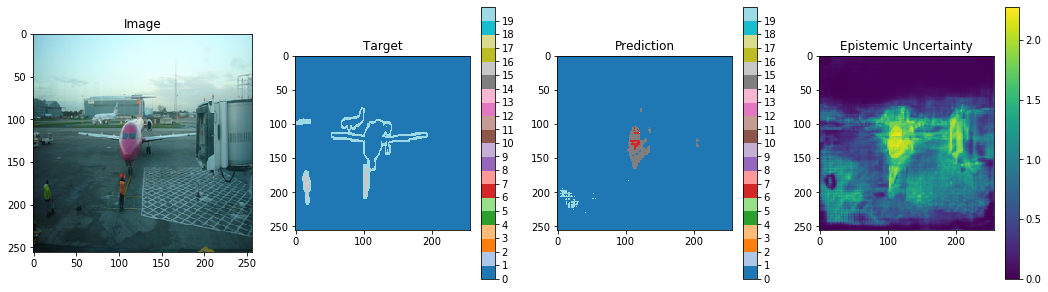

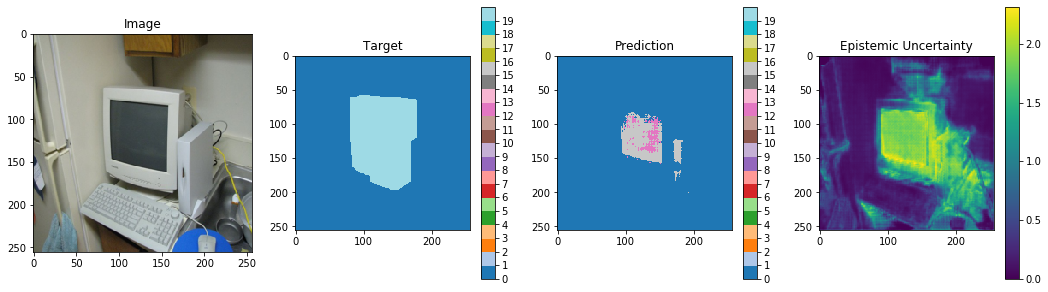

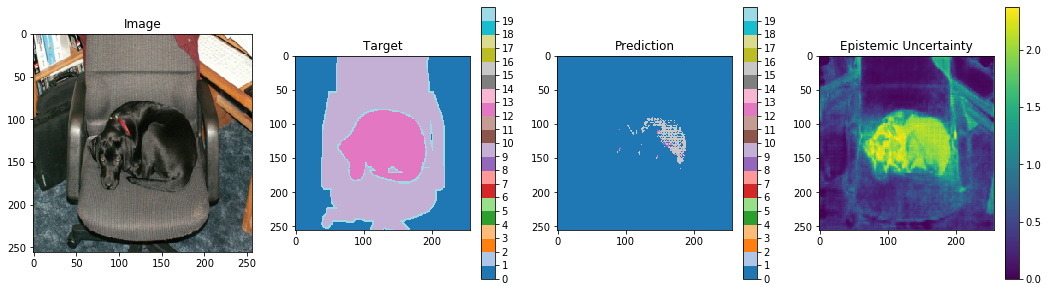

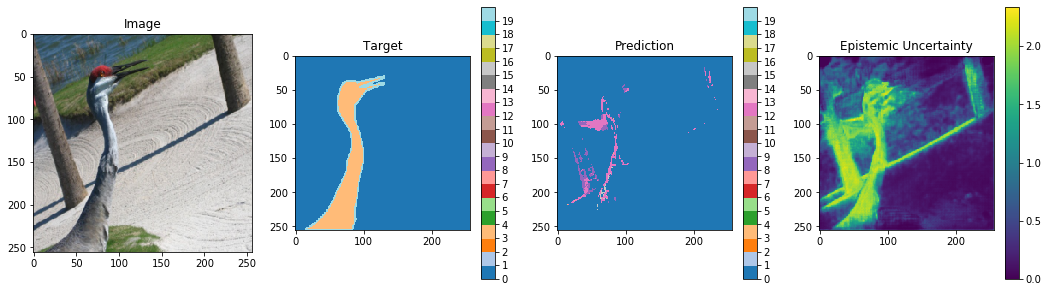

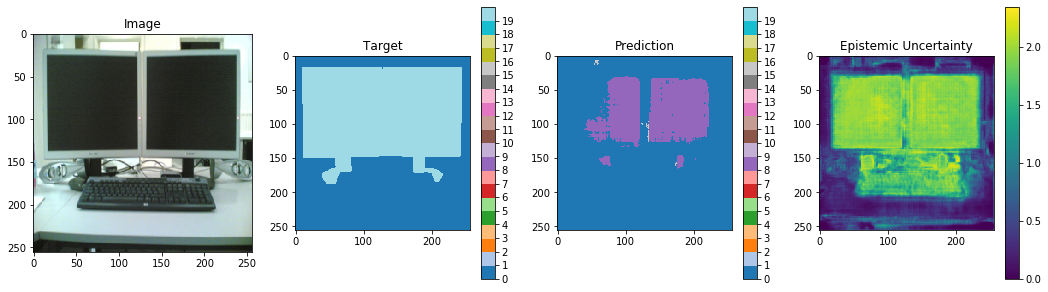

In [11]:

for index in range(5):
    x, y = test_data[index]
    x = x.cuda()

    ps = []
    for _ in range(10):
        o = model(x[None])
        p = F.softmax(o, dim=1)
        ps.append(p)

    ps = torch.stack(ps, dim=0)
    p_average = torch.mean(ps, dim=0)
    klass = torch.argmax(p_average, dim=1)
    _klass = klass.data.cpu().numpy()

    entropy = -torch.sum(p_average * torch.log(p_average + 1e-5), dim=1)
    _entropy = entropy.data.cpu().numpy()

    plt.figure(figsize=[18, 5])
    plt.subplot(1, 4, 1)
    plt.title('Image')
    plt.imshow(x.data.cpu().numpy().transpose(1, 2, 0))

    plt.subplot(1, 4, 2)
    plt.title('Target')
    plt.imshow(y.data.cpu().numpy(), vmin=0, vmax=20, cmap='tab20')
    plt.colorbar(ticks=np.arange(0, 20))

    plt.subplot(1, 4, 3)
    plt.title('Prediction')
    plt.imshow(_klass[0], vmin=0, vmax=20, cmap='tab20')
    plt.colorbar(ticks=np.arange(0, 20))

    plt.subplot(1, 4, 4)
    plt.title('Epistemic Uncertainty')
    plt.imshow(_entropy[0])
    plt.colorbar()
    plt.show()

In [49]:
from torchvision import datasets, transforms
from PIL import Image
from albumentations import (RandomRotate90, Transpose, ShiftScaleRotate, Blur, HueSaturationValue, GaussNoise, 
                            RandomContrast, RandomBrightness, Flip, Compose)

class VOCSegmentationAug(datasets.VOCSegmentation):
    def __init__(self, root, year, image_set, download, transform, target_transform):
        super().__init__(root, year, image_set, download, transform, target_transform)
        self.transform = transforms.Compose([transforms.Resize((Height, Width)),
                                             transforms.ToTensor()])
    
    def _transform(self, x, y):
        return self.transform(x), self.transform(y)
        
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        x, y = self._rotate(x, y)
        x, y = self._flip(x, y)
        x, y = self._mirror(x, y)
        x, y = self._transform(x, y)
        y = (y * 255).long()
        
        return x, y
                                   

In [50]:
Width = 256
Height = 256

test_data = VOCSegmentationAug(root='voc', year='2012', image_set='val', 
                               download=True, 
                               transform=None, 
                               target_transform=None)

Using downloaded and verified file: voc/VOCtrainval_11-May-2012.tar


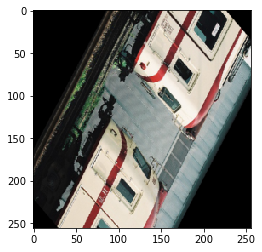

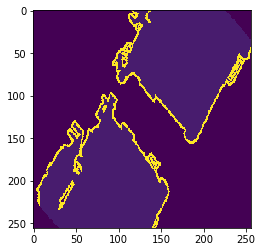

In [55]:
x, y = test_data[1]
plt.imshow(x.data.cpu().numpy().transpose(1, 2, 0))
plt.show()

plt.imshow(y.data.cpu().numpy()[0])
plt.show()

In [57]:
import albumentations

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [56]:
!pip install albumentations

     |████████████████████████████████| 117 kB 865 kB/s eta 0:00:01
     |████████████████████████████████| 948 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 49.3 MB 655 kB/s  eta 0:00:01
     |████████████████████████████████| 1.8 MB 15.6 MB/s eta 0:00:01
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65162 sha256=a4154eb6107b2f2fa80b2016532622781805d4402476035f7a0992e9f2da5346
  Stored in directory: /home/scpark/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.0.0.21
    Uninstalling opencv-python-4.0.0.21:
      Successfully uninstalled opencv-python-4.0.0.21
